In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### WHAT CASE ARE WE SOLVING?
Let's imagine that we work as a data scientist at the Booking company. One of the company's problems is dishonest hotels that wind up rating themselves. One of the ways to detect such hotels is to build a model that predicts the rating of the hotel. If the model's predictions are very different from the actual result, then perhaps the hotel is behaving dishonestly, and it is worth checking.

In [2]:
%%capture

# installing additional libraries
!pip install Afinn
!pip install nltk[twitter] 

# data analysis and processing tools
import pandas as pd
import numpy as np
import re
import geopy.distance
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# tools for linguistic analysis
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# options for displaying content on the screen:
from IPython.display import display
from IPython.display import Image
from termcolor import colored
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

# tools for building a model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

# we fix the RANDOM_SEED and the version of the packages so that the experiments are reproducible
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [3]:
# data from the competition
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

In [4]:
# combine train and test into one dataset
df_train['sample'] = 1 
df_test['sample'] = 0 

# in the test, we do not have a reviewer_score value, we fill it with zeros
df_test['reviewer_score'] = 0 

In [5]:
# Initial data
hotels = df_test.append(df_train, sort=False).reset_index(drop=True)
display(hotels.info())

hotels_isnull = hotels.isnull().sum()
print(f'\nColumns with explicit data omissions:\n{hotels_isnull[hotels_isnull > 0]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None


Columns with explicit data omissions:
lat    3268
lng    3268
dtype: int64


#### 1. Research and design of features (FEATURE ENGINEERING):
##### 1.1 A GROUP OF FEATURES CHARACTERIZING THE HOTEL
- Name and Address of the hotel ('hotel_address', 'hotel_name')
- The coordinates of the hotel are the geographical latitude and longitude of the hotel ('lat', 'lng')
- Average hotel score for the last year ('average_score')
- Total number of hotel reviews ('total_number_of_reviews')
- Total number of ratings without reviews ('additional_number_of_scoring')

In [6]:
# 'hotel_name'
# we examine the data on the name for the presence of omissions and duplicates
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()

name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = hotels['hotel_name'].isin(name_rep)
addresses_rep = hotels[mask][['hotel_name', 'hotel_address']].value_counts()

print(colored('Duplicating the Name of the hotel:', 'green'))
display(addresses_rep)

# to distinguish these hotels in the analysis, we will add a city to the name
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print(colored('\nLet\'s check the received changes:', 'green'))
mask = hotels['hotel_name'].str.contains(name_rep[0])
display(hotels[mask]['hotel_name'].value_counts())

Duplicating the Name of the hotel:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64


Let's check the received changes:


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

The name of the hotel can be used to train the model only if it is encoded. The name code itself can hardly tell you anything. There are more than a thousand hotels and the numeric code is more likely to confuse the model because of its dimension, which does not carry any semantic load.

Let's try to tell the model at least some meaningful information. The name is a unique characteristic of the hotel. Hotels can be sorted, for example, by popularity (number of reviews) or by rating (average score). But then it turns out that our attribute will duplicate in meaning either a column with the number of reviews, or a column with an average rating.

I'm more inclined to the idea of deleting this column, but later, at the stage of analyzing all the features and their impact on the target variable.

In the meantime, we will encode the name using both of these characteristics. Let us have only the best reviews and quite popular hotels (as an option).

In [7]:
# let's highlight the top of the best by rating, with a threshold of 100 reviews
hotels_names = hotels.groupby('hotel_name')['average_score'].agg(
    ['mean', 'count'])

mask = (hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]

print(colored(
    '\nThe best hotels with at least 100 reviews:', 'green'))

display(hotels_top)

hotels['hotel_cat'] = hotels['hotel_name'].apply(
    lambda x: x if x in hotels_top.index else 'other')

# let's apply ordinal ecoding
ord_encoder = OrdinalEncoder()
hotels['hotel_cat'] = hotels['hotel_cat'].astype('category')
hotels_bin = ord_encoder.fit_transform(hotels['hotel_cat'])
hotels = pd.concat([hotels, hotels_bin], axis=1)

# delete the original column
col = hotels.columns.tolist()
col[19] = 'hotel_code'

hotels.set_axis(col, axis=1, inplace=True)
hotels.drop('hotel_cat', axis=1, inplace=True);


The best hotels with at least 100 reviews:


,mean,count
hotel_name,,
41,9.600,103
Acad mie H tel Saint Germain,9.000,255
Alma Barcelona GL,9.200,179
Amba Hotel Charing Cross,9.300,785
Ambassade Hotel,9.300,551
...,...,...
Waldorf Astoria Amsterdam,9.500,142
art otel Amsterdam,9.000,790
citizenM London Bankside,9.100,1517


In [8]:
# 'hotel_address'
addresses = pd.Series(hotels['hotel_address'].unique())

print(colored(
    '\nLet\'s take a close look at the structure of the address data lines:', 'green'))
display(addresses)


Let's take a close look at the structure of the address data lines:


0                                       Via Senigallia 6 20161 Milan Italy
1                    Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
2                              Mallorca 251 Eixample 08008 Barcelona Spain
3             Piazza Della Repubblica 17 Central Station 20124 Milan Italy
4       Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
                                       ...                                
1488        45 Park Lane Westminster Borough London W1K 1PN United Kingdom
1489                          6 Avenue Fr miet 16th arr 75016 Paris France
1490                     22 avenue de Villiers 17th arr 75017 Paris France
1491                        17 rue de Richelieu 1st arr 75001 Paris France
1492                          64 Rue Crozatier 12th arr 75012 Paris France
Length: 1493, dtype: object

You can extract much more useful information from the address than from the name. Country, city and index as a characteristic of the area - can become additional features!

You can identify the area of the city by the index in the address bar of the hotel. The area of the city can greatly affect the tourist's impression of the hotel. Among other parameters, many tourists who leave reviews on Booking.com , often evaluate the location of the hotel.

In [9]:
# to determine geo-parameters, you can use locationtagger, 
# but it works quite slowly and with errors
# since we have a small number of unique countries and cities -
# let's use simple text processing:
countries = addresses.apply(lambda x: x.split()[-1])
countries = countries.apply(
    lambda x: 'United Kingdom' if x == 'Kingdom' else x)

cities = addresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x == 'United' else x)

addresses = pd.DataFrame(
    {'address': addresses, 'country': countries, 'city': cities})

print(colored(
    '\nIn each country, hotels are represented only from one city:', 'green'))
display(addresses.groupby(['country', 'city']).count())

# you can add one thing to the data - I will choose a country 
#(this way it will be more convenient to compare with the nationality of the reviewer later):
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

# # we encode information about the country
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes


In each country, hotels are represented only from one city:


,,address
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


In [10]:
def get_postcode(address:str) -> str:
    """extracting the zip code from the address string.
        Parameters:
        a (string): A address string
        Returns:
        postcode (str): a postcode
    """
    
    address_list = address.split()
    postcode_place = {
        'Kingdom': -4, 
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    postcode = str(address_list[postcode_place[address_list[-1]]])
    
    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode

    
# let's add the postal code of the hotel as the identifier of the area
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)


"""
I note that the division of the district into a type - center / historical center / the rest -
is quite conditional, there is no strict classification and there cannot be. Since 
there are very few cities in the data, I have placed the types of districts on my own,
using information for tourists from open sources.

It's just that I'm still at the very beginning of working on the project; I have a lot of excitement and
enthusiasm. And I don't know yet that transformations of this kind will
not significantly affect the final metrics.
"""

# from the file with data on the type of districts - we will determine the category of the district
districts = pd.read_csv('../input/districts/districts.csv')
districts['PostCode'] = districts['PostCode'].apply(lambda x: str(x))
districts = districts.set_index('PostCode')
districts = districts.to_dict()
districts = districts['Type of District']

hotels['district_type'] = hotels['hotel_postcode'].apply(lambda x: districts[x])

# we encode the type of area, preserving the hierarchy of tourist attractiveness
# (the historical center is the lowest index, the suburb is the opposite)
def get_district_code(district_type, country_code):
    """Assigning the area code depending on the category and city."""
    if district_type == 'History Center':
        return country_code
    elif district_type == 'Center':
        return country_code  + 6
    elif district_type == 'Other':
        return country_code + 12
    else:
        return country_code + 18

    
hotels['district_code'] = hotels.apply(
    lambda row: get_district_code(row['district_type'], row['hotel_country_code']
), axis=1)


# we will assign a category to the district depending on the popularity of hotels in it among tourists
# to do this, we normalize the information about the average rating of the hotel depending on the index:
pivot_adr = pd.pivot_table(
    hotels, 
    index='hotel_postcode', 
    values='average_score', 
    aggfunc='mean'
)
pivot_adr = pivot_adr.reindex(
    pivot_adr['average_score'].sort_values(ascending=False).index
)

mm_scaler = MinMaxScaler()
x_data = pivot_adr.values
x_scaled = mm_scaler.fit_transform(x_data)
pivot_adr['district_rating'] = x_scaled

hotels['district_rating'] = hotels['hotel_postcode'].apply(
    lambda x: pivot_adr['district_rating'][x]
)

hotels[['hotel_address', 
        'hotel_postcode', 
        'district_rating', 
        'district_type', 
        'hotel_country_code', 
        'district_code']][:10]

,hotel_address,hotel_postcode,district_rating,district_type,hotel_country_code,district_code
0,Via Senigallia 6 20161 Milan Italy,20161,0.502,Other,2,14
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,1043,0.695,Other,3,15
2,Mallorca 251 Eixample 08008 Barcelona Spain,08008,0.782,Center,4,10
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,20124,0.697,Center,2,8
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,1012,0.675,History Center,3,3
5,Coram Street Camden London WC1N 1HT United Kingdom,WC1,0.502,Center,5,11
6,Empire Way Wembley Brent London HA9 8DS United Kingdom,HA9,0.735,Center,5,11
7,1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom,W6,0.473,Other,5,17
8,35 Rue Caumartin 9th arr 75009 Paris France,75009,0.678,Center,1,7
9,49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom,W1,0.554,Center,5,11


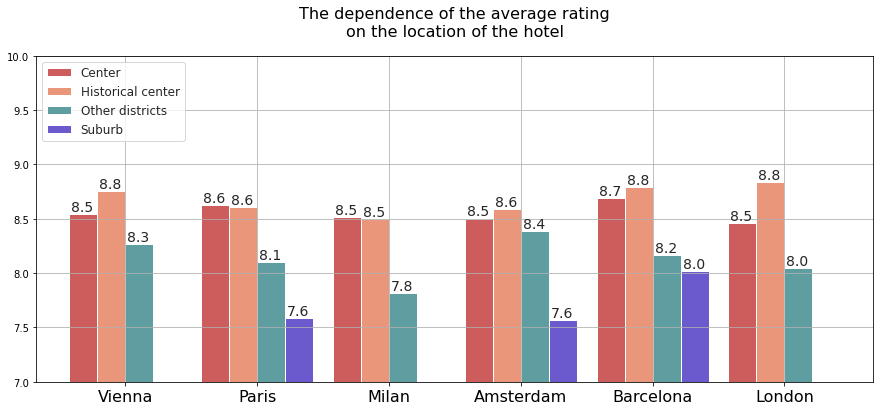

In [11]:
# We visualize the ratio of the average values of the target variable depending on the location of the hotel
pivot_district_type = hotels[hotels['sample'] == 1].groupby(
    ['hotel_country', 'district_type'])['reviewer_score'].mean().unstack()

cities_rus = ['Vienna', 'Paris', 'Milan', 'Amsterdam', 'Barcelona', 'London']

fig1, ax1 = plt.subplots(figsize=(15, 6))
sns.set_style('whitegrid')
district_type_plot = pivot_district_type.plot(
    ax=ax1, 
    kind='bar', 
    width=0.85, 
    color=['indianred', 'darksalmon', 'cadetblue', 'slateblue'],
    label=cities_rus, 
    rot=0)

ax1.set_title('The dependence of the average rating\non the location of the hotel', 
              pad = 20, size=16)
ax1.set_xlabel('')
ax1.set_xticklabels(cities_rus, fontsize=16)
ax1.legend(['Center', 'Historical center', 'Other districts', 'Suburb'], 
           loc='upper left', fontsize=12)

# for clarity, let's add data signatures to the diagram
for p in district_type_plot.patches:
    district_type_plot.annotate(
        '{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(7, 10);

In [12]:
# GEOGRAPHICAL COORDINATES OF THE HOTEL ('lat', 'lng')
# In general, the coordinates themselves can tell the model little, but you can try to extract some useful 
# information from them. For example, the distance to the city center. From the information about the dataset, 
# we remember that it is in these columns that there are gaps. First we will remove the omissions, then we 
# will add a new feature.
without_coor = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts())
print(f'Number of hotels with missing coordinates: {without_coor}')

# calculate the average coordinate values for each district
pivot_coor = pd.pivot_table(
    hotels, 
    index='hotel_postcode', 
    values=['lat', 'lng'], 
    dropna=True, 
    aggfunc='mean')

hotels['lat'] = hotels.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] \
    if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] \
    if np.isnan(row['lng']) else row['lng'], axis=1)

Number of hotels with missing coordinates: 17


In [13]:
# to form a new feature, the coordinates of the center of each city are needed 
# (from the website: https://dateandtime.info /)
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')


def get_dist_to_center(country, lng, lat):
    """Calculating the distance to the city center by coordinates."""
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km


"""
You can calculate coordinates with one line of code, using lambda.
But geopy.distance.geodesic function is quite slow.
In order not to process 500 thousand lines, we will calculate this characteristic
for each hotel and compare the results obtained.

"""

hotels_unique = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)
hotels = hotels.merge(hotels_unique, how='left', on='hotel_name', sort=False)

# now columns with coordinates can be deleted
hotels.drop(['lng', 'lat'], axis=1, inplace=True)

print(colored('\nLet\'s check the new feature:', 'green'))
hotels[['hotel_name', 'hotel_distance_to_center']][:15]


Let's check the new feature:


,hotel_name,hotel_distance_to_center
0,Hotel Da Vinci,7.838
1,Urban Lodge Hotel,6.244
2,Alexandra Barcelona A DoubleTree by Hilton,0.564
3,Hotel Principe Di Savoia,1.873
4,Hotel Esther a,0.404
5,Holiday Inn London Bloomsbury,1.736
6,Holiday Inn London Wembley,18.457
7,Novotel London West,10.595
8,Hotel Saint Petersbourg Opera,3.100
9,St George Hotel,3.766


AVERAGE HOTEL SCORE ('average_score')<br>
It seems that this is one of the most self-sufficient signs. This is a quantitative parameter of the hotel, in the same dimension and format as the target variable. There is no need to perform any transformations with it, and its impact on the indicators of the target variable will be evaluated in the next block - the analysis of features.

TOTAL NUMBER OF HOTEL REVIEWS ('total_number_of_reviews')<br>
TOTAL NUMBER OF RATINGS WITHOUT FEEDBACK ('additional_number_of_scoring')<br>
The total number of reviews is an indicator of the popularity and/or size of the hotel. But, in my subjective feeling, it does not greatly affect the tourist's assessment. He, along with the second indicator, rather speaks about the representativeness of the average score of the hotel. I think these signs are not significant, we will leave the question of their removal until the stage of feature selection.<br>

P.S. I was wrong here. After building the final model, the indicator of the total number of reviews got into the top important ones. Indeed, hotels that have few reviews are usually new hotels with high ratings that take great care of their rating on the site and show more attention to the guests. And finally, it's just more pleasant for a tourist to be in new hotels.

##### 1.2 A GROUP OF FEATURES CHARACTERIZING THE REVIEWER AND HIS EXPERIENCE OF STAYING AT THE HOTEL
- Reviewer's country ('reviewer_nationality')
- Tags that the reviewer gave to the hotel ('tags')
- The number of reviews that reviewers have given in the past ('total_number_of_reviews_reviewer_has_given')

REVIEWER'S COUNTRY ('reviewer_nationality')<br>
In fact, I think that it is not so much the country as the socio-cultural characteristics of representatives of certain regions that can really affect hotel ratings.
<br>
For example, tourists from English-speaking countries almost never encounter a language barrier in European hotels. And this is an important factor when settling in, finding out additional information and solving emerging problems. It follows that most likely such tourists will be more satisfied with their stay at the hotel.
<br>
But tourists from Middle Eastern countries may be dissatisfied with European hotels more than others, since their lifestyle is more different from the European one.
<br>
Let's add additional features:

In [14]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
nationality_count = len(hotels["reviewer_nationality"].value_counts())
print(f'Representatives of {nationality_count} countries are reviewers.')

# let's analyze, for example, the 40 most common countries, 
# from which tourists come and we will highlight common groups
print(colored('\nThe most popular countries:', 'green'))
print(list(hotels['reviewer_nationality'].value_counts(ascending=False)[:40].index))

# let's highlight the main English-speaking countries
english_list = ['United Kingdom', 
                'United States of America', 
                'Australia', 
                'Canada', 
                'New Zealand']
hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in english_list else 0)

# let's highlight the Muslim countries of the Middle East region
muslim_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar', 
               'Oman']
hotels['reviewer_n_est'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in muslim_list else 0)

# add a sign of the tourist's residence in relation to the country in which the hotel is located
hotels['reviewer_resident'] = hotels.apply(
    lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

# we encode information about the reviewer's country
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
hotels['reviewer_nationality_cat'] = hotels['reviewer_nationality'].cat.codes


Representatives of 227 countries are reviewers.

The most popular countries:
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Germany', 'Canada', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'India', 'Greece', 'China', 'Sweden', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal', 'Finland']


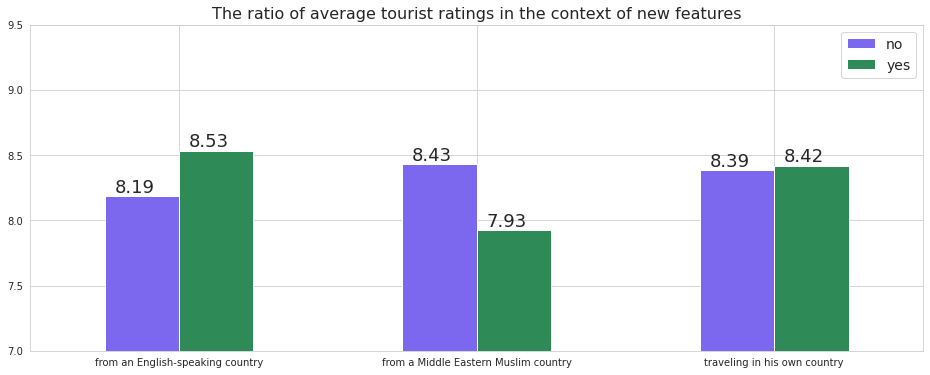

In [15]:
# We visualize the ratio of the average values of the target variable in the context of the obtained features
# prepare the data for the chart
mask = hotels['sample'] == 1
pivot_en = hotels[mask].groupby('reviewer_en')['reviewer_score'].mean()
pivot_n_est = hotels[mask].groupby('reviewer_n_est')['reviewer_score'].mean()
pivot_resident = hotels[mask].groupby('reviewer_resident')['reviewer_score'].mean()

pivot = pd.DataFrame({
    'from an English-speaking country': pivot_en,
    'from a Middle Eastern Muslim country': pivot_n_est,
    'traveling in his own country': pivot_resident
}).T

# building a diagram
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    ax=ax2, 
    kind='bar', 
    color=['mediumslateblue', 'seagreen'], 
    rot=0)
ax2.set_title(
    'The ratio of average tourist ratings in the context of new features', size=16)
ax2.legend(['no', 'yes'], loc='upper right', fontsize=14)

# for clarity, let's add data signatures to the diagram
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=18)

plt.ylim(7, 9.5);


##### 'tags'

Visualize the most popular tags of the dataset:


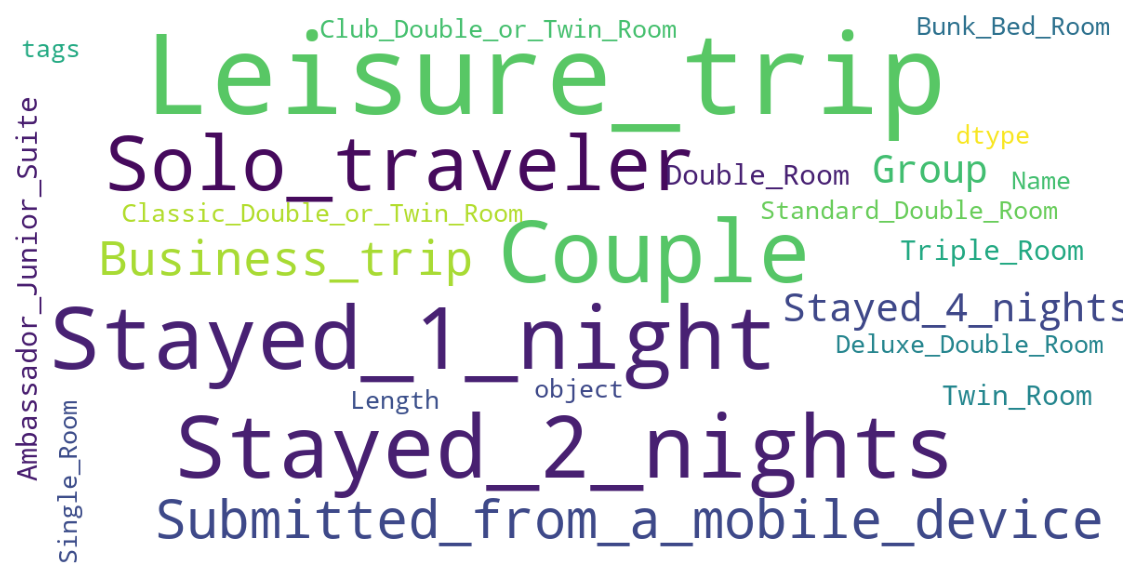

In [16]:
# let's save the way of visualizing words in the function, it will still come in handy
def show_wordcloud(data, background_color, colormap):
    """Draw a word cloud with the specified parameters."""
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 40,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

    
print('Visualize the most popular tags of the dataset:')

# to see the merged Tags on the visualization, and not individual words, 
# converting data strings into blocks for each tag
def get_tags_string(tags_data):
    """We connect all the words of each tag with an underscore."""
    tags_data = tags_data.replace('[', '').replace(']', '').replace("'", '')
    tags_list = tags_data.split(',')

    tags_string = ''
    for teg in tags_list:
        teg = teg.strip().replace(' ', '_')
        tags_string = tags_string + teg + ' '

    return tags_string

# рисуем диаграмму:
cloud = hotels['tags'].apply(get_tags_string)
show_wordcloud(cloud, 'white', 'viridis')

In [17]:
# Let's consider and analyze the types of tags
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))

print(f'Maximum number of tags in 1 data row: {hotels["len_tags"].max()}\n')

print('Примеры:')
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[0])
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[1])

Maximum number of tags in 1 data row: 6

Примеры:
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


#### There are 6 types of tags:
- traveling with pets
- travel for work / leisure
- travel in what composition (one, couple, group of friends, family with small / adult children, group)
- room category
- duration of the trip
- access is carried out from a mobile device

In [18]:
"""
The principle of highlighting useful properties is as follows - we know that the maximum
number of tags is 6 and we know their possible types. All of them, except for the type of room,
fit into a standard template. We will search for one of the five
known tag templates in each line and delete it from the line after processing. If it stays 
some other tag - it will be the type of number.
"""

# creating new features
def get_tags(tags_string):
    """Highlighting 6 types of tags by templates."""
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # we immediately encode the type of traveler
    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    # forming new parameters
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 # by default, we do not consider the trip a business trip
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    
    # we distribute those tags that are in the source line
    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)

        if teg == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(teg)

        if teg == 'Leisure trip':
            tags_list.remove(teg)

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', teg)][0]           
            tags_list.remove(teg)
            
        if len(tags_list) > 0:
            tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type


# forming new features
hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index)

print(colored('\nThe number of unique values in the new attributes:', 'green'))
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()


The number of unique values in the new attributes:


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       32
tag_room_type        2394
dtype: int64

Let's take a close look at the room categories. It may be possible to separate them into groups. It seems that the reviews about the stay of tourists who stay in a large club room with a view and in a small economy can be very different.<br>

From the room type, we will additionally highlight the attribute - a room with a view (I think that the average score of guest reviews of such rooms should be higher than usual).

In [19]:
# optimizing the data type (for the following diagram)
hotels['tag_count_nights'] = hotels['tag_count_nights'].astype('int8')

# add a feature of a room with a view
hotels['tag_view_room'] = hotels['tag_room_type'].apply(
    lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)


# let's form a list of the main categories of hotel rooms 
# and assign the corresponding value to each group
def get_room_type(tag):
    """Классификация типа номера."""
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 
                  'Standard', 'Superior', 'Comfort', 'Club', 'Suite', 
                  'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


# grouping data with the number type
hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

# coding new features
encoder_t = OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

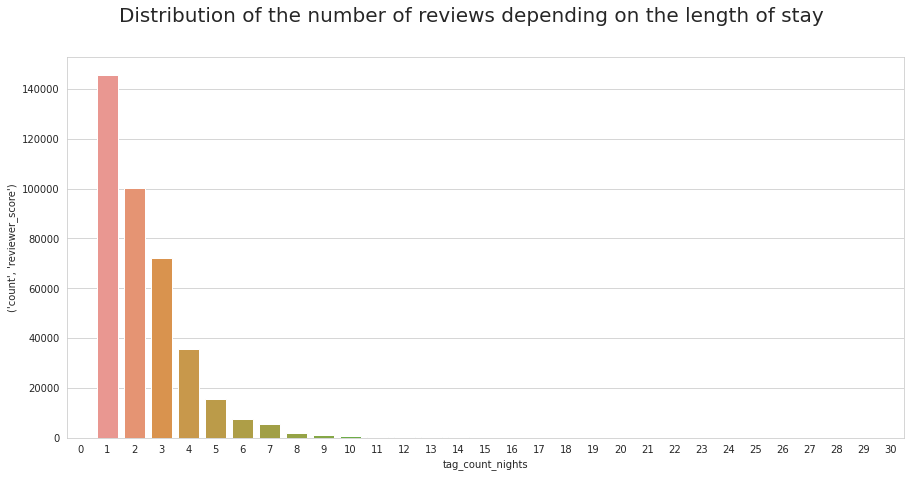

In [20]:
# We visualize the distribution table of the target variable in the context of the number of days spent in the hotel, 
# as well as the ratio of its average values depending on the room category
pivot_nights = pd.pivot_table(
    hotels[hotels['sample'] == 1], 
    index='tag_count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Distribution of the number of reviews depending on the length of stay', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

The largest groups are tourists who have made short trips lasting 1-3 nights. Logically, for city hotels. As the length of stay increases, the number of reviews gradually decreases, and after an indicator of 14 nights (the standard length of a vacation), their number drops sharply.<br>

It is strange that some data does not have information about the length of stay at the hotel. In general, the site carefully checks the reviews for reality. Perhaps these are trips retroactively canceled by the hotel with a refund to the tourist, for example, and a review of the stay has already been published. If you pay attention to the reviews, then these are mostly negative reviews. We will not replace these values with averages.<br>

And now let's see if there is a dependence of average ratings on room categories:

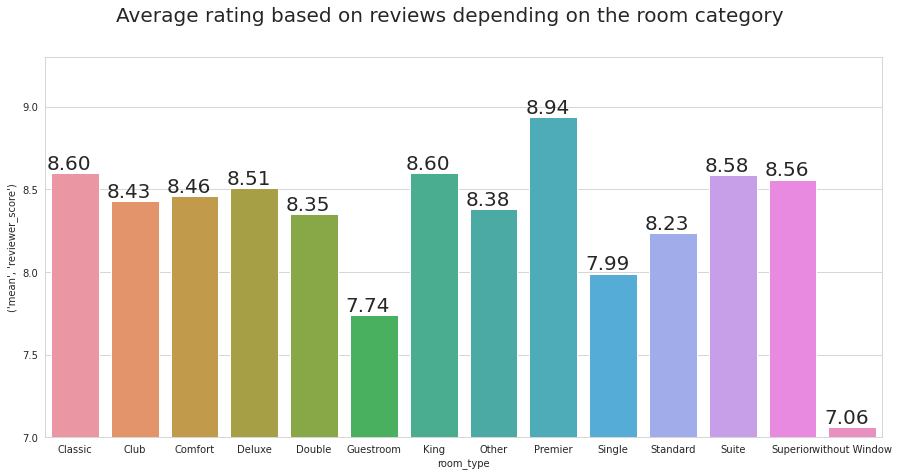

In [21]:
# visualize the differences in the ratings of tourists, depending on the type of room
pivot_types = pd.pivot_table(hotels[hotels['sample'] == 1], 
                             index='room_type', 
                             values='reviewer_score', 
                             aggfunc=['count', 'mean'])

fig4, ax4 = plt.subplots(figsize=(15, 7))
plt.suptitle('Average rating based on reviews depending on the room category', size=20)
bar_types = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

In [22]:
# remove auxiliary columns
hotels.drop(['tag_reviewer_type', 'room_type', 'tag_room_type', 'len_tags'], 
            axis=1, inplace=True)

#### TOTAL NUMBER OF REVIEWER REVIEWS ('total_number_of_reviews_reviewer_has_given')
It seems that such a parameter as the number of reviews from the reviewer does not affect the rating of the hotel at all. But it is possible, of course, that "experienced" travelers are more demanding and strict about the accommodation object. Or on the contrary, people who travel a lot - they know better what they want and have more experience in choosing an accommodation facility. This means that they are less likely to be disappointed... These hypotheses need to be tested. We will leave the decision on the removal to the stage of analysis and selection of features.

In [23]:
print(colored(
    '\nLet\'s look at the number of reviewers\' reviews by activity groups:', 'green'))
print(hotels['total_number_of_reviews_reviewer_has_given'].groupby(
    pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], 
           np.arange(0, 360, 25))).agg('count'))

# логарифмируем значение признака, чтобы оставить только информацию 
# о степени (порядке) активности рецензента:
hotels['total_number_of_reviews_reviewer_has_given'] = \
    hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))


Let's look at the number of reviewers' reviews by activity groups:
total_number_of_reviews_reviewer_has_given
(0, 25]       488425
(25, 50]       21640
(50, 75]        3914
(75, 100]       1149
(100, 125]       294
(125, 150]       144
(150, 175]       119
(175, 200]        21
(200, 225]        12
(225, 250]         8
(250, 275]         2
(275, 300]         4
(300, 325]         4
(325, 350]         1
Name: total_number_of_reviews_reviewer_has_given, dtype: int64


#### 1.3 TIME CHARACTERISTICS - DATES AND PERIODS
- Date the review was posted ('review_date')
- The difference between the recall date and the data upload date ('days_since_review')

##### DATE THE REVIEW WAS POSTED ('review_date')
I have a hypothesis that the assessment of a tourist, a parameter that is certainly subjective, is often influenced not only by the experience of staying in a hotel, but also by the atmosphere of travel in general.

- It is no secret that the best time to travel to major European cities, many consider the period of winter New Year and Christmas holidays. The streets of European megacities are turning into big Christmas fairs, and the hotels have a relaxed festive atmosphere. It seems that this should greatly affect the overall rating of the hotel.
- Spring is also a great time to visit European cities. It's already quite warm for walking, but there are no crowds of annoying tourists.
- Summer, of course, is a controversial period. It's vacation time and even city hotels are often crowded. But a long-awaited visit to Paris or Milan can spoil the heat, for example, problems with air conditioning, or queues at breakfast. The staff often cannot cope with a large flow of visitors, hence, I assume that the estimates of visiting the hotel in the summer will be among the lowest.
- Well, autumn. In autumn, European hotels are also not sweet :D. Cold, dank days begin, the rooms are often cold and damp. After the summer tourist season, it is in autumn that many hotels arrange repairs for the Christmas holidays, which can cause additional discomfort to guests.
It seems to me that it is most logical to distinguish into separate signs - the month, week and time of the year of visiting the hotel.
<br>
PS. Subsequently, I abandoned the idea of forming the season into a separate feature. Both ordinal and categorical coding of the season of the year worsened the final MAPE.

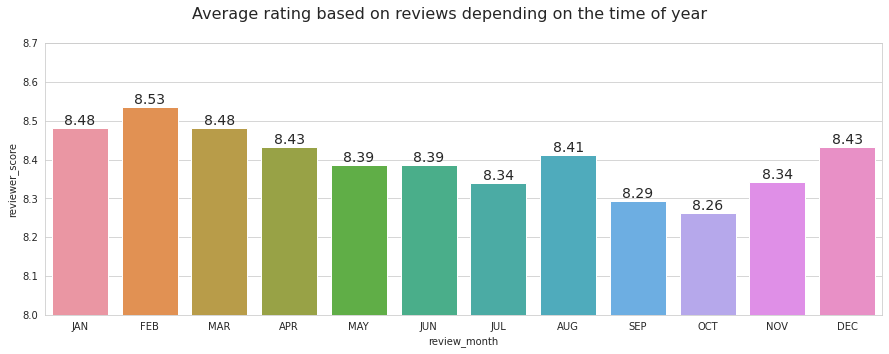

In [24]:
# convert the data in the column to date/time format
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# forming new features
hotels['review_week'] = hotels['review_date'].apply(
    lambda x: x.isocalendar()[1])
hotels['review_month'] = hotels['review_date'].dt.month

# Visualize the effect of a month of visiting a hotel on the average mood of tourists:
mask = hotels['sample'] == 1
pivot_month = hotels[mask][['review_month', 'reviewer_score']].groupby(
    'review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Average rating based on reviews depending on the time of year', size=16)
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score'])
ax5.set_xticklabels([
    'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
    'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

### THE AGE OF THE REVIEW IN DAYS WHEN UPLOADING DATA ('days_since_review')
I can't even guess here - how the age of the review can affect the rating. It is possible to put forward a hypothesis, except that “people used to be kinder.” But since the limitation period in our data is limited to only 2 years, even she, in my opinion, is not wealthy :D Information about possible seasonality has already been obtained from the date, and we will remove this feature with a clear conscience, without postponing it until the stage of feature selection.

In [25]:
hotels.drop('days_since_review', axis = 1, inplace=True)

### 1.4 REVIEWS
- Negative review that the reviewer gave to the hotel ('negative_review')
- Positive review that the reviewer gave to the hotel ('positive_review')
- Total number of words in a negative review ('review_total_negative_word_counts')
- Total number of words in a positive review ('review_total_positive_word_counts')

The structure of the hotel review on the website “Booking.com ” it is arranged in such a way that it contains two parts: A negative review and a Positive review.<br>

After rating by category, the reviewer is asked to answer two questions:

- What didn't you like about the accommodation?
- What did you like about the accommodation?
- Thus, two parts of one essentially review are obtained.

#### NUMBER OF WORDS IN THE REVIEW
If you calculate the actual number of words in a line with a review, then it will differ from the data by 1-2 points. And the number of words equal to 0 corresponds to the labels 'No Positive' / 'No Negative', that is, the actual absence of a review. I do not consider this fact critical and leave the data in this aspect without transformations.
<br>
These signs already directly give us information about whether the tourist is satisfied with his stay at the hotel. In most cases, if everything was fine, the question: What didn't you like? - you will not answer anything or you will do with a standard phrase like "I liked everything" or "Everything was fine!". If there is something to complain about, this part of the review will be much longer. The positive part is the same. Let's test this hypothesis:

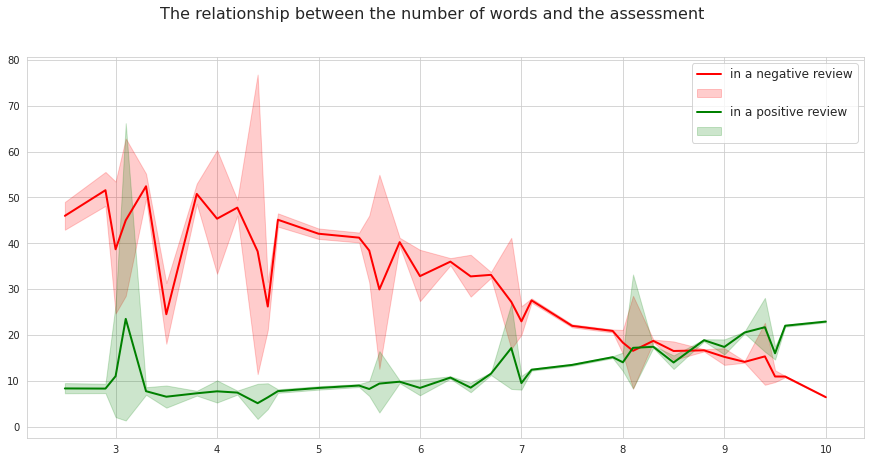

In [26]:
fig6, ax6 = plt.subplots(figsize=(15, 7))
plt.suptitle('The relationship between the number of words and the assessment', size=16)
line_count_neg = sns.lineplot(
    data=hotels[mask],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos = sns.lineplot(
    data=hotels[mask],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)
ax6.set_xlabel('')
ax6.set_ylabel('')
ax6.legend(['in a negative review', '', 'in a positive review', ''], 
           loc='upper right', fontsize=12);

##### A lyrical digression about the rating system on Booking.com
In fact, the connection is much stronger than it might seem. This is due to the specifics of rating on the site Booking.com . Until 2019, it seems, the rating system there was as follows:
<br>
The reviewer evaluates 6 categories in 4 degrees. Each category - 10 points in total, for each step + 2.5 points to the sum of the category, and the final score is the arithmetic mean rounded to tenths.
<br>
If we visualize the distribution of all estimates, we will see the main movement just for these 19 values:

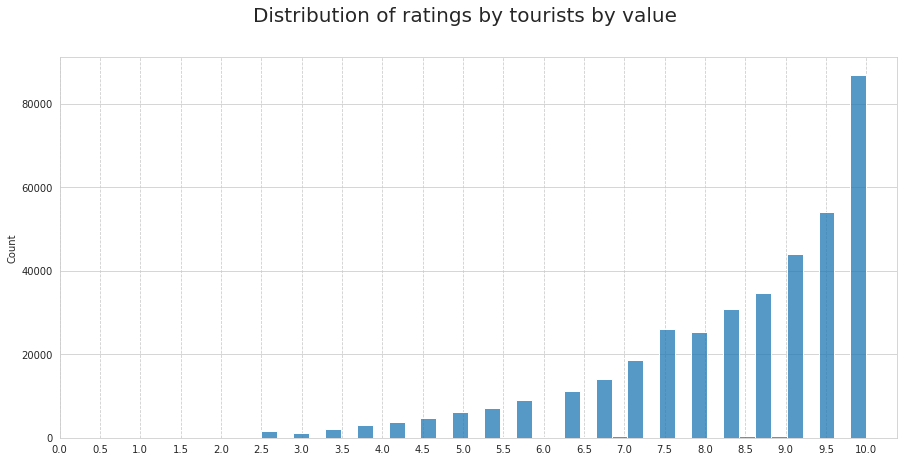

In [27]:
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle('Distribution of ratings by tourists by value', size=20)
sns.histplot(
    ax=ax1, 
    data=hotels[mask]['reviewer_score'], 
    bins=len(hotels['reviewer_score'].value_counts())
).xaxis.grid(linestyle='--')
ax1.set_xticks(np.arange(0, 10.5, 0.5))
ax1.set_xlabel('');

In [28]:
# let's divide the list of all estimates with their quantities into two parts
#1) those that fit into the evaluation system
#2) the rest
scores_list_1 = hotels[mask]['reviewer_score'].value_counts().iloc[:19]
scores_list_2 = hotels[mask]['reviewer_score'].value_counts().iloc[19:]

print(colored('\nAssessments that fit into the assessment system Booking.com:', 'green'))
display(scores_list_1)

print(colored('\nAssessments that don\'t fit into the assessment system Booking.com:', 'green'))
display(scores_list_2)


Assessments that fit into the assessment system Booking.com:


10.000    86803
9.600     53502
9.200     44053
8.800     34795
8.300     30903
7.500     26164
7.900     24901
7.100     18529
6.700     14117
6.300     11244
5.800      8962
5.400      7082
5.000      6278
4.600      4660
4.200      3827
3.800      3017
3.300      2063
2.500      1632
2.900      1211
Name: reviewer_score, dtype: int64


Assessments that don't fit into the assessment system Booking.com:


9.500    523
9.000    483
8.000    388
8.500    379
7.000    293
6.500    274
6.000    184
5.500    161
4.500     97
4.000     66
3.500     61
9.400     47
8.100     28
3.000     25
6.900     23
5.600     13
4.400      9
3.100      6
Name: reviewer_score, dtype: int64

If you look at the dynamics of the most popular ratings, then these are the same 10, 9.6, 9.2 and so on. Quite a normal one-sided (or exponential) distribution.
<br>
But where the rest of the estimates came from, in increments of 0.5, is not very clear. The total number of them is less than a percent of the total number. Maybe it's, for example, the results of testing an alternative evaluation system, or just corrupted data, or something else.

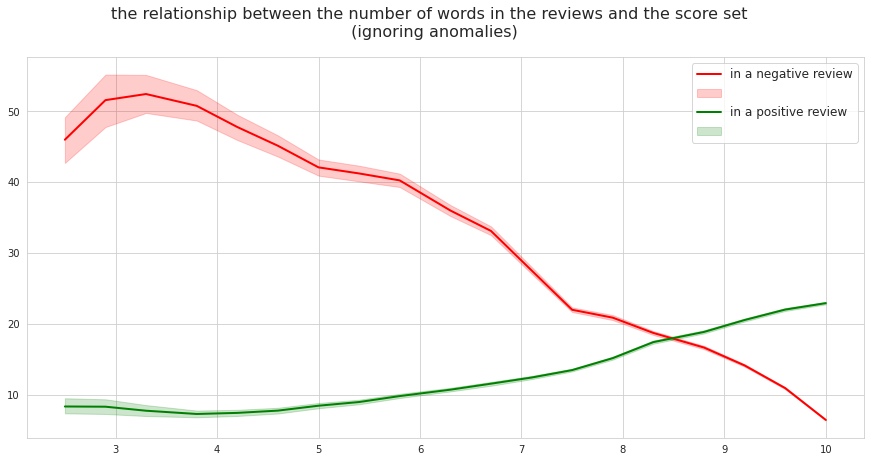

In [29]:
# and now we visualize the relationship between the number of words in the review and the level of evaluation 
# excluding these 1% abnormal values
hotels_filtered = hotels[
    mask & (hotels['reviewer_score'].isin(scores_list_1.index.to_list()))]

fig7, ax7 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'the relationship between the number of words in the reviews and the score set \n (ignoring anomalies)', 
    size=16)
line_count_neg = sns.lineplot(
    data=hotels_filtered,
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos = sns.lineplot(
    data=hotels_filtered,
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)
ax7.set_xlabel('')
ax7.set_ylabel('')
ax7.legend(['in a negative review', '', 'in a positive review', ''], 
           loc='upper right', 
           fontsize=12);

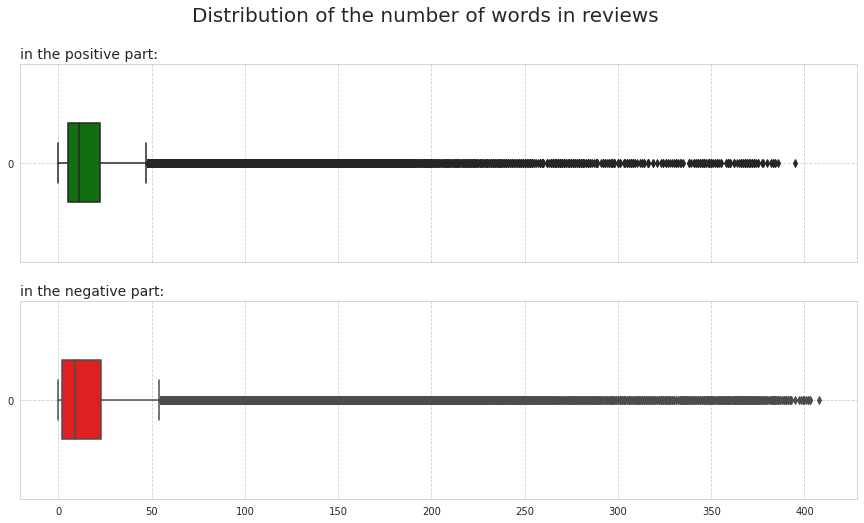

In [30]:
# the end of the lyrical digression.
# Let's look at the distributions of these features:

# forming chart sizes
fig10, ax10 = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(15, 8))
plt.suptitle('Distribution of the number of words in reviews', size=20)

sns.boxplot(
    ax=ax10[0], 
    data=hotels['review_total_positive_word_counts'], 
    color='green', 
    width=0.4, 
    orient='h'
).grid(linestyle='--')

sns.boxplot(
    ax=ax10[1], 
    data=hotels['review_total_negative_word_counts'], 
    color='red', 
    width=0.4, 
    orient='h'
).grid(linestyle='--')
ax10[0].set_title('in the positive part:', ha='left', x=.0, fontsize=14)
ax10[1].set_title('in the negative part:', ha='left', x=.0, fontsize=14);

The distributions are one-sided (similar to the distributions of the target attribute), a large spread of values beyond the boundary of the third quartile is certainly not anomalies, but the specifics of these data. The complementary influence of the number of words in the two parts of the review is one of the strongest dependencies in this dataset.
<br>
At first, I had ideas to somehow process the number of words, limit them using the Tukey method, or, for example, logarithm the data. But not one of these transformations did not give a significant improvement in the final metrics, and I refused them. Apparently, the scale of each type of data separately does not greatly affect the proposed algorithm for constructing the model (Random Forest).
<br>
It makes sense to bring the data to a single dimension only if you need to compare them with each other.
<br>
The target variable demonstrates dependence on both values. Let's combine both effects into one, adding the difference in the number of words in the positive and negative parts of the review (previously normalize both scales):

In [31]:
mm_scaler = MinMaxScaler()

hotels['review_total_positive_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

hotels['review_total_negative_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# let's combine these indicators into one, negative words - with a negative coefficient
hotels['review_total_word_counts_diff_norm'] = \
    hotels['review_total_positive_word_counts_norm'] - \
    hotels['review_total_negative_word_counts_norm']

# and also add a flag - do positive words prevail over negative ones 
# in the dimensions of the corresponding ranges
hotels['positive_words_more'] = hotels['review_total_word_counts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0)

hotels.drop(
    ['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], 
    axis=1, inplace=True)

In [32]:
# We will also add a fraction of one of the parts (the second indicator will be inversely proportional, obviously - not significant)

hotels['review_total_word_counts'] = \
    hotels['review_total_positive_word_counts'] + \
    hotels['review_total_negative_word_counts']

# if the total number of words is 0, then we consider both parts to be equivalent (0.5 each)
hotels['review_positive_word_proportion'] = hotels.apply(
    lambda row: 0.5 if row['review_total_word_counts'] == 0 \
            else row['review_total_positive_word_counts'] / row['review_total_word_counts'],
axis=1)

# deleting the auxiliary column
hotels.drop('review_total_word_counts', axis = 1, inplace=True)

#### DIRECT REVIEW (‘negative_review', ‘positive_review')
And now - the most interesting:D A huge amount of information for a better prediction of the final score is contained in these columns!
<br>
But in order to parametrically evaluate these data, a linguistic analysis of the text will be needed. I'll try two approaches:

- VADER (Valence Aware Dictionary and sEntiment Reasoner) is a vocabulary and rules—based sentiment analysis tool specifically tuned to feelings expressed on social media.


- TextBlob is a Python library (2 and 3) for processing text data. It provides a simple API for immersion in common natural language processing (NLP) tasks, such as tagging parts of speech, name phrase extraction, tonality analysis, classification, translation, and more.


- Own ideas of text classification

In [33]:
import nltk
nltk.download('omw-1.4')

True


A CLOUD OF WORDS OF POSITIVE REVIEWS:



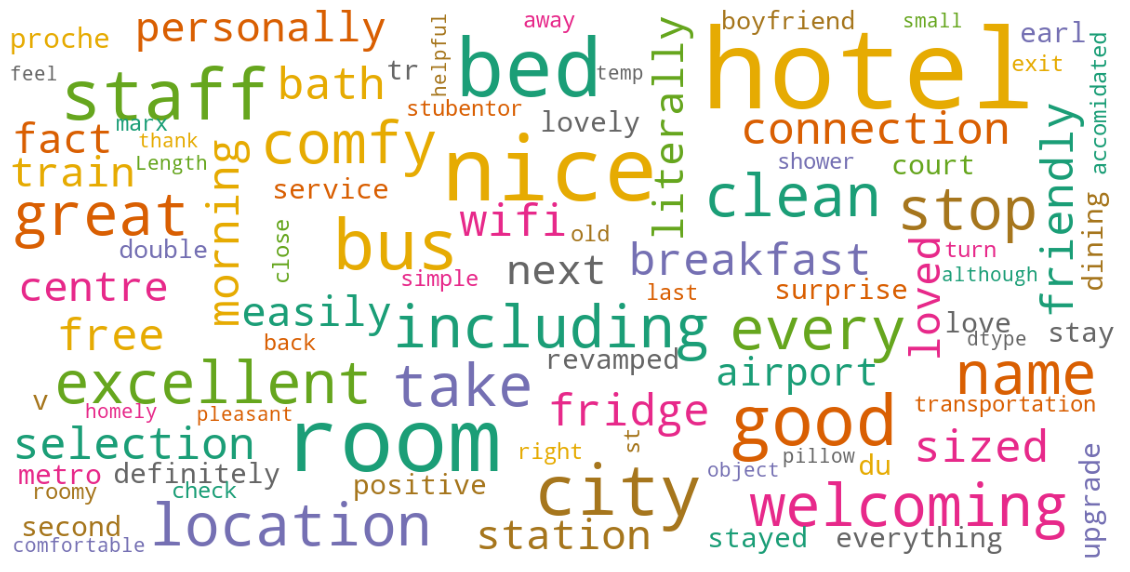

In [34]:
#  Let's start this fascinating study with a beautiful visualization of the most popular words (it's worth the next 30 lines of code):

# visualize the main words of the positive and negative parts of the reviews
# loading the dictionary for lemmatization
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def clean_text(text):
    """Clearing of stop words and lemmatization of text"""
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


def get_words_string(words_data):
    """Combining the cleared words into a single string"""
    words_string = ''
    for word in words_data:
        words_string = words_string + word + ' '
    return words_string


def draw_cloud(text_column, background, color_map):
    """Visualization of vocabulary sets"""
    hotels['temp'] = hotels[text_column].apply(
        lambda x: x.replace('No Negative', '').replace('No Positive', ''))
    hotels.temp = hotels[text_column].apply(clean_text)
    cloud_data = hotels.temp.apply(get_words_string)
    # воспользуемся функцией для визуализации тегов:
    show_wordcloud(cloud_data, background, color_map)

print('\nA CLOUD OF WORDS OF POSITIVE REVIEWS:\n')
draw_cloud('positive_review', 'white', 'Dark2');


WORD CLOUD OF NEGATIVE REVIEWS:



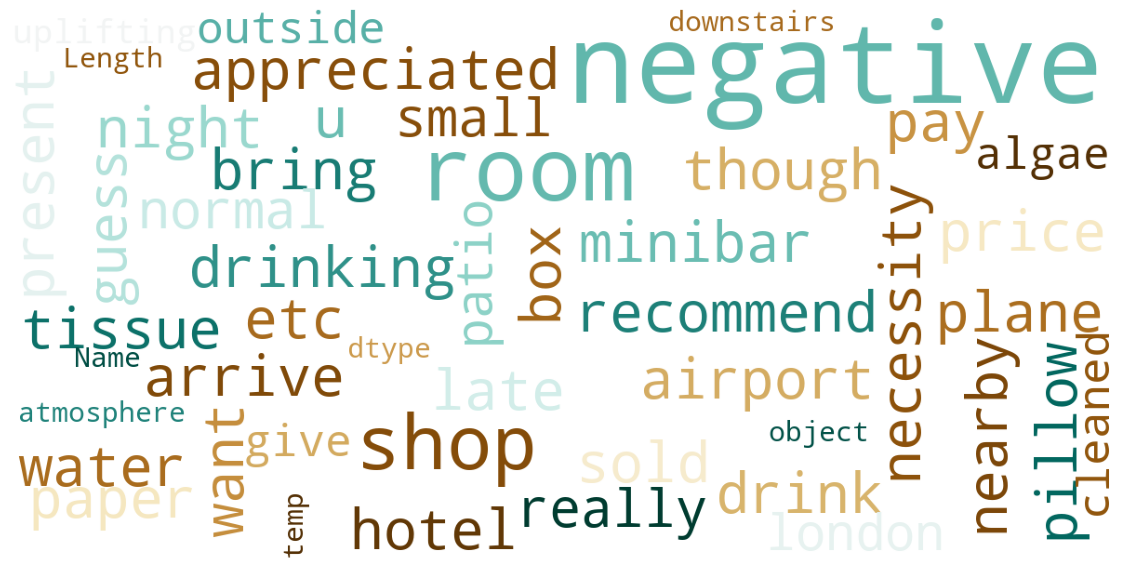

In [35]:
print('\nWORD CLOUD OF NEGATIVE REVIEWS:\n')
draw_cloud('negative_review', 'white', 'BrBG');

#### Sentiment analysis using the SentimentIntensityAnalyzer of the VADER library:
SentimentIntensityAnalyzer from VADER outputs an assessment at 3 classification levels, as well as a composite assessment. As a result, we will get a dictionary of normalized estimates of the tonality of the text by category:

- negative assessment
- neutral assessment
- positive

From the VADER documentation on composite evaluation: composite evaluation is calculated by summing the valence estimates of each word in the lexicon, adjusted according to the rules, and then normalized so as to be in the range from -1 (extreme negative value) to +1 (extreme positive value).
<br>
And everything would be fine, but the same words in positive and negative contexts will have the opposite tonality.
#### “Everything“ or ”Nothing"?
Remember that the positive and negative parts of the review are answers to two questions of the site about what you liked / disliked at the hotel. And the structure of the English language is such (as it turned out) that the answer to the question “What didn't you like?”: “Nothing” (nothing) - will mean that you didn't like anything, that is, you liked everything. The most positive context. But the same “Nothing” in response to the question: “What did you like?” will mean exactly the opposite.
<br>
But the word “everything” (everything) does not have such semantics (it seems).
<br>
These words initially have a neutral tonality for the analyzer, but as an answer to the question, it would be good to change this tonality of such the most popular words. And in a different way for different parts of the reviews.
<br>
It should be understood that, of course, these words can occur not only in short answers, but also in expanded sentences, where they will not make such sense. But they will not have much weight in the overall assessment. We can ignore these situations.
<br>
We will also find the word “small” in a huge part of negative reviews - Small room, Small bed, Small pool. And the innocently neutral small in negative hotel reviews takes on a negative context.
<br>
To work with different parts of the reviews, I will create two different analyzers - SentimentIntensityAnalyzer, and I will configure the lexicon of each for the corresponding part of the reviews.
<br>
And one more thing. In general, the labels ‘No Negative’ / ‘No Positive’ indicate the absence of a review. If you leave everything as it is, then the analyzer will discard “No” and give out the tonality of the opposite word in meaning. You can delete these values altogether by replacing them with an empty string, but for us the absence of a negative review means the absence of a negative experience of staying and vice versa, so we will leave these phrases for analysis, having previously reformulated the phrases without “not”. But if nothing is written at all, then the mutual multidirectional tonalities of both labels will give a neutral 0 in total.

In [36]:
# creating two instances of the analyzer to separate the lexicon
# for different rating systems of positive and negative reviews
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# let's see how the characteristic of the word 'nothing' changes
example = 'nothing'
print(f'Dictionary of estimates of the word "{example}" before transformations:')
print(sia_neg.polarity_scores(example), '\n')

# add context
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - after transformations (for negative context):')
print(sia_neg.polarity_scores(example))
print(f' - after transformations (for a positive context):')
print(sia_pos.polarity_scores(example))

# phrases "No Negative" will tonally carry a negative connotation
example = 'No Negative'
print(f'\nDictionary of phrase ratings "{example}":')
print(sia_neg.polarity_scores(example))
example = 'Positive'
print(f'Dictionary of phrase ratings "{example}":')
print(sia_neg.polarity_scores(example))

# changing the labels of the absence of parts of the review:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

Dictionary of estimates of the word "nothing" before transformations:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - after transformations (for negative context):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - after transformations (for a positive context):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Dictionary of phrase ratings "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Dictionary of phrase ratings "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [37]:
%%time
hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])

CPU times: user 4min 32s, sys: 3.22 s, total: 4min 35s
Wall time: 4min 36s


##### Sentiment analysis using TextBlob:
TextBlob works a little differently. Unlike Vader, it analyzes not words, but phrases and sentences, giving out parameters such as: polarity and subjectivity.

The polarity is a floating point number from -1 to 1, where -1 is a negative statement and 1 is a positive statement. Subjectivity is a TextBlob indicator that determines whether a statement is considered to be more of a personal opinion or it is based on facts.

To assess the mood of the reviewer, we will use the polarity parameter.

Also, using NaiveBayesAnalyzer, you can get a classification of moods (similar to Vader) in the negative and positive parts of the review and, based on these data, we will deduce the category of the review, guided by the following logic:

- (enthusiastic) both parts have a positive tone: the highest category of the tourist liked everything so much that in the answer to the question about the shortcomings - he expresses positive emotions

- (constructive) the positive part has a positive tone, the negative part has a negative one: medium high category objective search for the advantages and disadvantages of the hotel

- (condescending) the positive part has a negative tone, the negative one has a positive one: the average low category of the stay rather did not like it, but the feedback about the shortcomings is not hard

- (disappointed) both parts have a negative tone: the lowest category didn't like anything

Based on the rating scale of the hotel, we will choose 4 ratings in the range from 2.5 to 10 in equal increments.

P.S. here I don't know yet that this feature-the classification will most likely have to be removed due to the strong correlation with another factor

In [38]:
# since this analyzer does not work with words, but with phrases, 
# then it copes with the expressions 'No Negative' / 'No Positive'
text_example = 'No Negative'
example = TextBlob(text_example)
print(f'The polarity of the phrase "{text_example}": \
{round(example.sentiment_assessments.polarity,2)}')

text_example = 'No Positive'
example = TextBlob(text_example)
print(f'The polarity of the phrase "{text_example}": \
{round(example.sentiment_assessments.polarity,2)}')

The polarity of the phrase "No Negative": 0.15
The polarity of the phrase "No Positive": -0.11


In [39]:
%%time

def get_polarity(text):
    """Getting the feedback polarity parameter"""
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity

hotels['positive_polarity'] = hotels['positive_review_temp'].apply(get_polarity)
hotels['negative_polarity'] = hotels['negative_review_temp'].apply(get_polarity)

CPU times: user 6min 48s, sys: 206 ms, total: 6min 48s
Wall time: 6min 48s


Also in the library there is a way to get the coefficients of negative and positive coloring (in total they give 1) and classify the text depending on which component prevails.

In [40]:
%%time

tb = Blobber(analyzer=NaiveBayesAnalyzer())

text_example = 'everything was great'
print(f'{tb(text_example).sentiment} for the phrase "{text_example}"')

# # since the positive and negative components are mutually inverse quantities, forming a total of 1 - 
# # you can limit yourself to just one
def get_blobber_sentiment(text):
    """Getting a positive rating coefficient"""
    blobber_sentiment = tb(text).sentiment
    return blobber_sentiment[1]

hotels['positive_review_pos'] = hotels['positive_review_temp'].apply(get_blobber_sentiment)
hotels['negative_review_pos'] = hotels['negative_review_temp'].apply(get_blobber_sentiment)

Sentiment(classification='pos', p_pos=0.6252594845412645, p_neg=0.37474051545873566) for the phrase "everything was great"
CPU times: user 5min 28s, sys: 456 ms, total: 5min 28s
Wall time: 5min 30s


In [41]:
# let's add a classification to the review depending on the proportion of the positive component
hotels['positive_review_class'] = hotels['positive_review_pos'].apply(
    lambda x: 1 if x >= 0.5 else 0)
hotels['negative_review_class'] = hotels['negative_review_pos'].apply(
    lambda x: 1 if x >= 0.5 else 0)


# adding a parameter with the classification of the review
def get_class(positive_review_class, negative_review_class):
    """Classification of the recall, depending on the classes of both parts"""
    if positive_review_class + negative_review_class == 2:
        return 10.0
    if positive_review_class == 1 and negative_review_class == 0:
        return 7.5
    if positive_review_class == 0 and negative_review_class == 1:
        return 5.0
    return 2.5


hotels['review_classification'] = hotels.apply(
    lambda row: get_class(row['positive_review_class'], row['negative_review_class']), 
    axis=1)

Our own experiments:
Using previous methods, we obtained several classifications based on sentiment analysis, but not taking into account the specific vocabulary of reviewers writing specifically about hotels. In fact, there are a lot of constructive reviews describing the advantages in detail, but without strong emotions. And I want to understand that the reviewer talks about the hotel in the key of the most laudatory reviews.

I tried to find an easy way to compare all the reviews with the best and identify some kind of similarity coefficient. But how to understand which are the best?

I will try to create a certain set of words typical for positive reviews, based on the positive part of reviews of the best hotels (with the highest average rating). Then we will estimate what percentage of the words of each review intersect with this set.

(By the way, with negative reviews - this approach did not work, since people often write negative reviews in more detail, even if they do not significantly reduce the rating.)

In [42]:
%%time

# we form a single block of text of both parts of the review and get rid of the labels of the absence of words
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', ''))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']


# the function of converting a string into a set of words
def get_words_set(text):
    """Formation of sets of unique words of the text"""
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if len(word) > 2]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    words_data = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    words_set = set()
    for word in words_data:
        words_set.add(word)
    return words_set


# we form sets of unique words for each review
hotels['review_word_set'] = hotels['review'].apply(get_words_set)

CPU times: user 1min 56s, sys: 1.13 s, total: 1min 57s
Wall time: 1min 58s


In [43]:
best_words_set = set()

# let's pick up samples of the text of reviews about the best hotels
hotels_top = pd.DataFrame(hotels[hotels['average_score'] >= 9.6])
hotels_top['positive_review_word_set'] = hotels_top['positive_review'].apply(get_words_set)
hotels_top_list = hotels_top['positive_review_word_set'].tolist()

for review_set in hotels_top_list:
    best_words_set.update(review_set)

best_hotels_count = len(hotels[hotels['average_score'] >= 9.6]['hotel_name'].value_counts())

print(f'The number of unique words selected based on the results of {len(hotels_top_list)} reviews '
      f'{best_hotels_count} of the best hotels: {len(best_words_set)}.')

The number of unique words selected based on the results of 943 reviews 7 of the best hotels: 2044.


In [44]:
def get_diff_with_top(review_words_set):
    """Determining the proportion of review words also found in reviews of top hotels"""
    set_len = len(review_words_set)
    if set_len == 0:
        return 0
    top_words_count = 0
    for word in review_words_set:
        if word in best_words_set :
            top_words_count += 1

    return round(top_words_count / set_len, 2)


# forming a new feature
hotels['review_difference_with_top'] = hotels['review_word_set'].apply(get_diff_with_top)

Bonus! Short code with Afinn:
In fact, there are a huge number of solutions to the problems of sentiment analysis, a bunch of libraries and various analyzers. The ones I used are probably the most popular and quite understandable to a beginner.

However, wandering through the vast expanses of the Internet, I came across another concise and simple way to get the mood coefficient of the text. Afinn is an approach to sentiment analysis based on a list of words. It does not normalize the scores and we get a coefficient correlated with the scale of the number of words of the review. That is, a kind of word-weighted assessment:

In [45]:
%%time
# getting the score:
afinn = Afinn()
hotels['afinn_score'] = hotels['review'].apply(lambda x: afinn.score(x))

CPU times: user 10min 3s, sys: 135 ms, total: 10min 3s
Wall time: 10min 3s


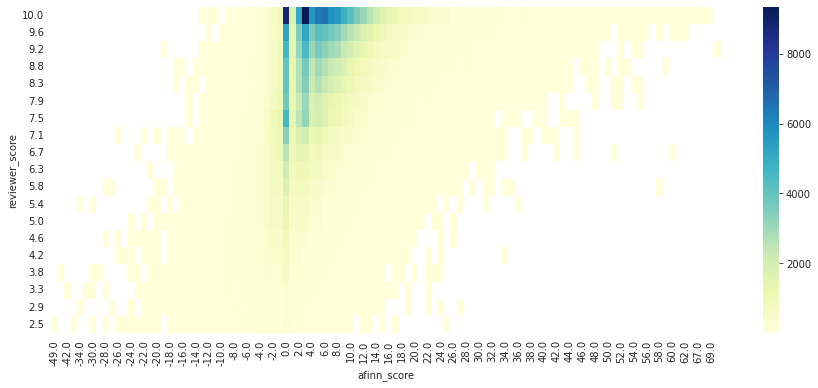

In [46]:
# We visualize the ratio of tourist ratings and afinn coefficients
# beautiful heat map at the end of the section:
hotels_filtered = hotels[mask & (hotels['reviewer_score'].isin(
    scores_list_1.index.to_list()))]
pivot = hotels_filtered.pivot_table(
    values='review', 
    index='reviewer_score', 
    columns='afinn_score', 
    aggfunc='count')

# building a diagram:
fig8, ax8 = plt.subplots(1, 1, figsize = (15, 6))
afinn_heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
ax8.invert_yaxis();

In [47]:
# we will limit the size of the range of values according to the Tukey method
def get_outliers_bonds(data, feature):
    """Defining the boundaries of ranges to limit values"""
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


lower_bound, upper_bound = get_outliers_bonds(hotels, 'afinn_score')

hotels['afinn_score'] = hotels['afinn_score'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

### 2. Analysis and selection of features (FEATURE SELECTION):

In [48]:
# creating a duplicate database for further manipulations with columns (for reversibility of experiments):
hotels_copy = hotels.copy()

In [49]:
print(f'The current resulting number of features: {len(hotels_copy.columns)}')
print('(including the target column and the test/train label)')

# delete non-numeric data:
object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | \
                      (hotels[s].dtype.name == 'category') | \
                      (hotels[s].dtypes == 'datetime64[ns]'))]

print(f'Deleting {len(object_columns)} columns with non-numeric data')
hotels_copy = hotels_copy.drop(object_columns, axis = 1)

The current resulting number of features: 81
(including the target column and the test/train label)
Deleting 17 columns with non-numeric data


In [50]:
# Let's divide the numerical signs into groups
# continuous and categorical features
num_cols = [
    # related to the number of words
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'review_total_word_counts_diff_norm', 'review_positive_word_proportion',

     # related to the analysis of the emotional coloring of reviews
    'n_review_sentiments_neg', 'n_review_sentiments_neu',
    'n_review_sentiments_pos', 'n_review_sentiments_compound',
    'p_review_sentiments_neg', 'p_review_sentiments_neu',
    'p_review_sentiments_pos', 'p_review_sentiments_compound',
    'negative_polarity', 'positive_polarity', 
    'negative_review_pos', 'positive_review_pos', 
    'review_difference_with_top', 'afinn_score',

    # other quantitative
    'total_number_of_reviews_reviewer_has_given', 'tag_count_nights'
]

cat_cols = [
    # hotel features
    'average_score', 'additional_number_of_scoring', 'total_number_of_reviews',
    'hotel_code', 'hotel_country_code', 'district_code', 
    'district_rating', 'hotel_distance_to_center',

    # characteristics of the trip (number)
    'tag_leisure_trip', 'tag_view_room', 'room_type_without Window', 
    'room_type_Suite', 'room_type_Standard', 'room_type_Double',
    'room_type_Superior', 'room_type_Club', 'room_type_Comfort', 
    'room_type_Deluxe', 'room_type_Premier', 'room_type_Classic', 
    'room_type_King', 'room_type_Single', 'room_type_Guestroom', 'room_type_Other',

    # characteristics of the reviewer
    'reviewer_en', 'reviewer_n_est', 'reviewer_resident', 'reviewer_nationality_cat', 
    'tag_from_mobile', 'tag_with_pet',
    'tag_reviewer_type_1.0', 'tag_reviewer_type_2.0', 'tag_reviewer_type_3.0',
    'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0',

    # travel time
    'review_week', 'review_month',

    # features reviews
    'review_classification', 'positive_words_more', 
    'negative_review_class', 'positive_review_class',
]

#### 2.1 MULTICOLLINEARITY ANALYSIS
Since there are a lot of signs, we will evaluate collinearity by semantic groups:

ANALYSIS OF MULTICOLLINEARITY OF CONTINUOUS FEATURES

In [51]:
def show_corr_heatmap(columns_list, title, method):
    """Construction of a correlation diagram"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = hotels[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

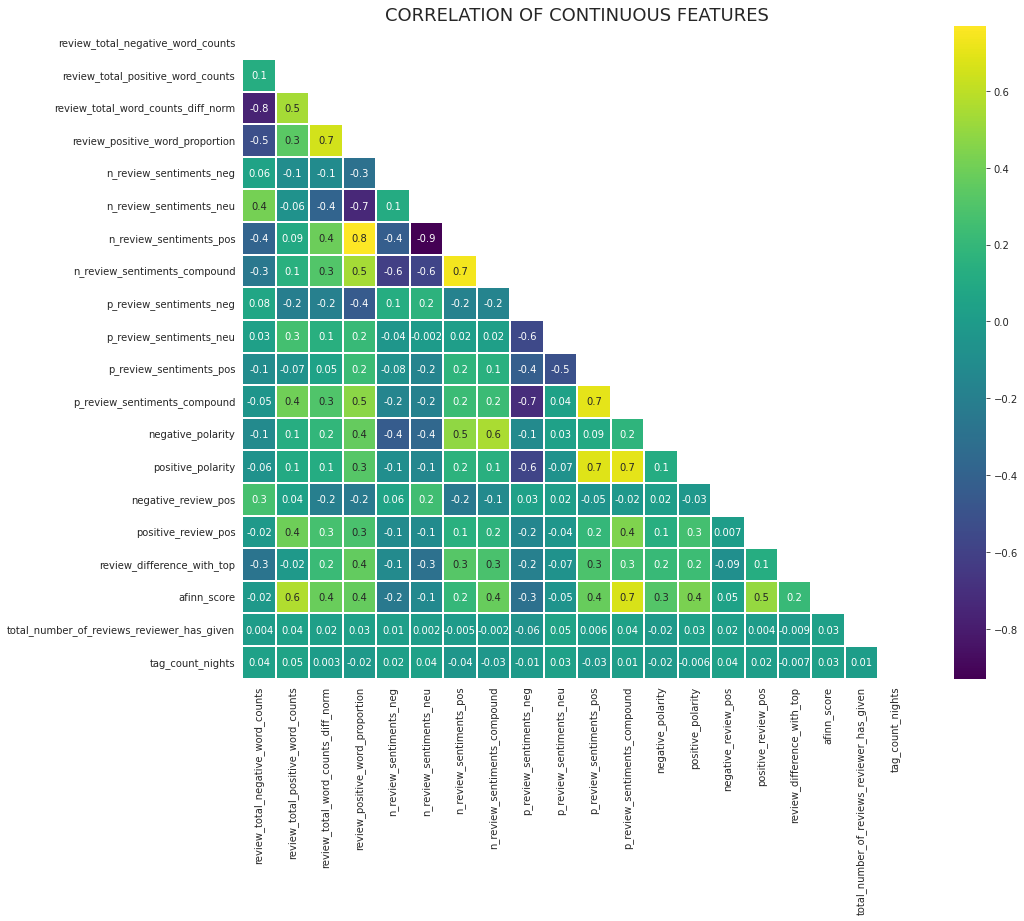

In [52]:
#building a diagram for continuous features
show_corr_heatmap(num_cols, 'CORRELATION OF CONTINUOUS FEATURES', method='pearson');

In [53]:
# We select for deletion two signs from pairs having a correlation modulus greater than 0.8.
# add columns to the list for deletion
drop_columns = ['n_review_sentiments_neu']

#### ANALYSIS OF MULTICOLLINEARITY OF CATEGORICAL FEATURES
Let 's divide categorical features into 2 semantic groups:

In [54]:
# in the first block we will take the characteristics of the hotel and the rooms
cat_cols_p1 = cat_cols[:24]

# in the second block - characteristics of the reviewer, travel time and review
cat_cols_p2 = cat_cols[24:]

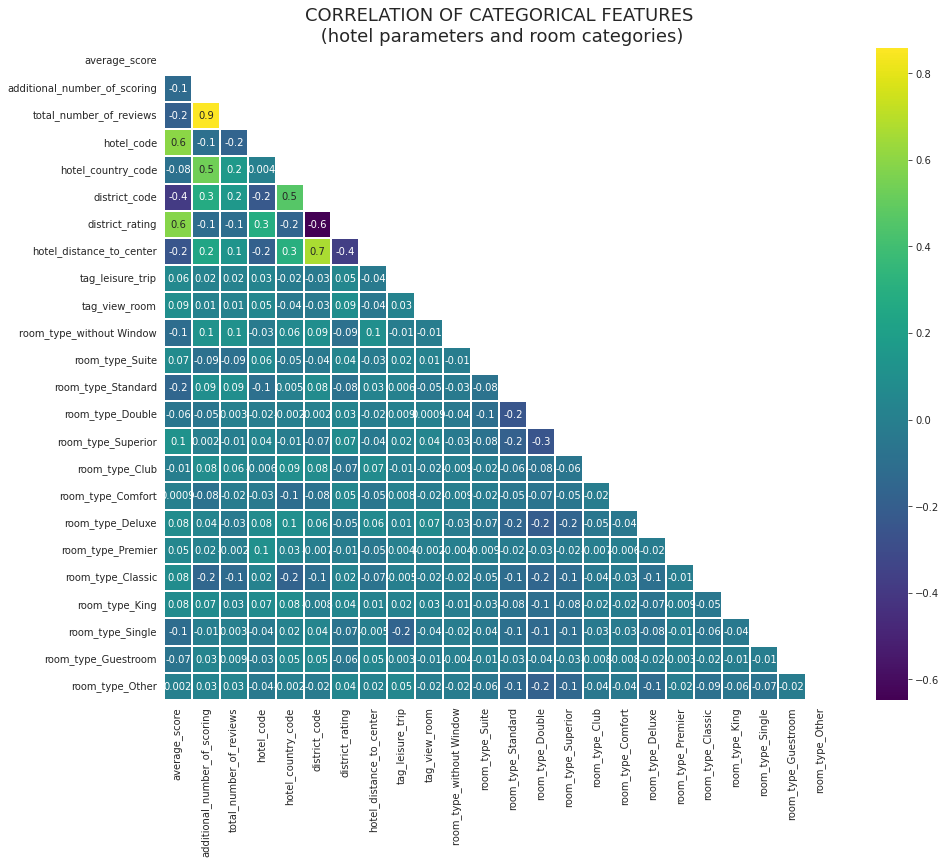

In [55]:
# building a diagram for the first part of categorical features:
show_corr_heatmap(
    cat_cols_p1, 
    'CORRELATION OF CATEGORICAL FEATURES\n (hotel parameters and room categories)', 
    method='spearman'
);

In [56]:
# add columns to the list for deletion
drop_columns += ['additional_number_of_scoring']

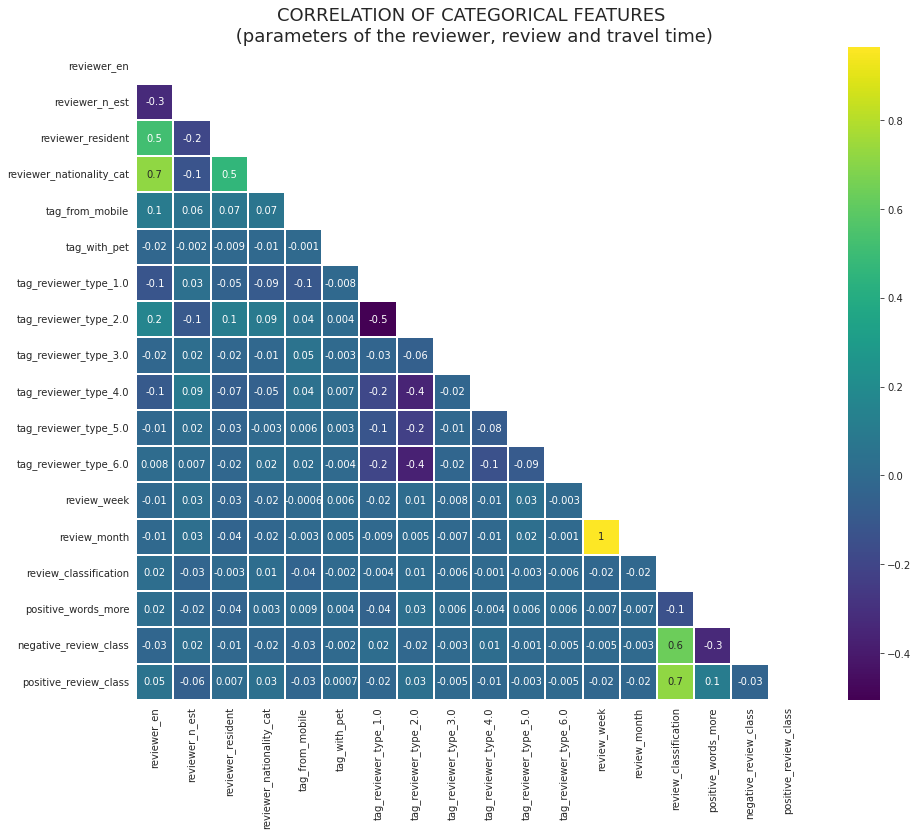

In [57]:
# building a diagram for the second part of categorical features:
show_corr_heatmap(
    cat_cols_p2, 
    'CORRELATION OF CATEGORICAL FEATURES\n (parameters of the reviewer, review and travel time)', 
    method='spearman'
);

In [58]:
# And from this list, you can remove the sign of the week or month (delete the month) and the classification of the review (it strongly correlates with the signs from which it is derived).
# add columns to the list for deletion
drop_columns += ['review_month', 'review_classification']
# delete the selected columns:
hotels_copy.drop(drop_columns, axis = 1, inplace=True)

print(f'The current resulting number of features: {len(hotels_copy.columns)}')
print('(including the "Sample" column and the target column)')


The current resulting number of features: 60
(including the "Sample" column and the target column)


#### 2.2 ASSESSMENT OF THE SIGNIFICANCE OF THE SIGNS
We will evaluate the significance of the signs. I would classify our target feature into a category - quantitative discrete. Let's use ANOVA analysis of variance for evaluation. Now it is not correct to divide the signs into groups, we need to get absolutely the worst in the whole aggregate

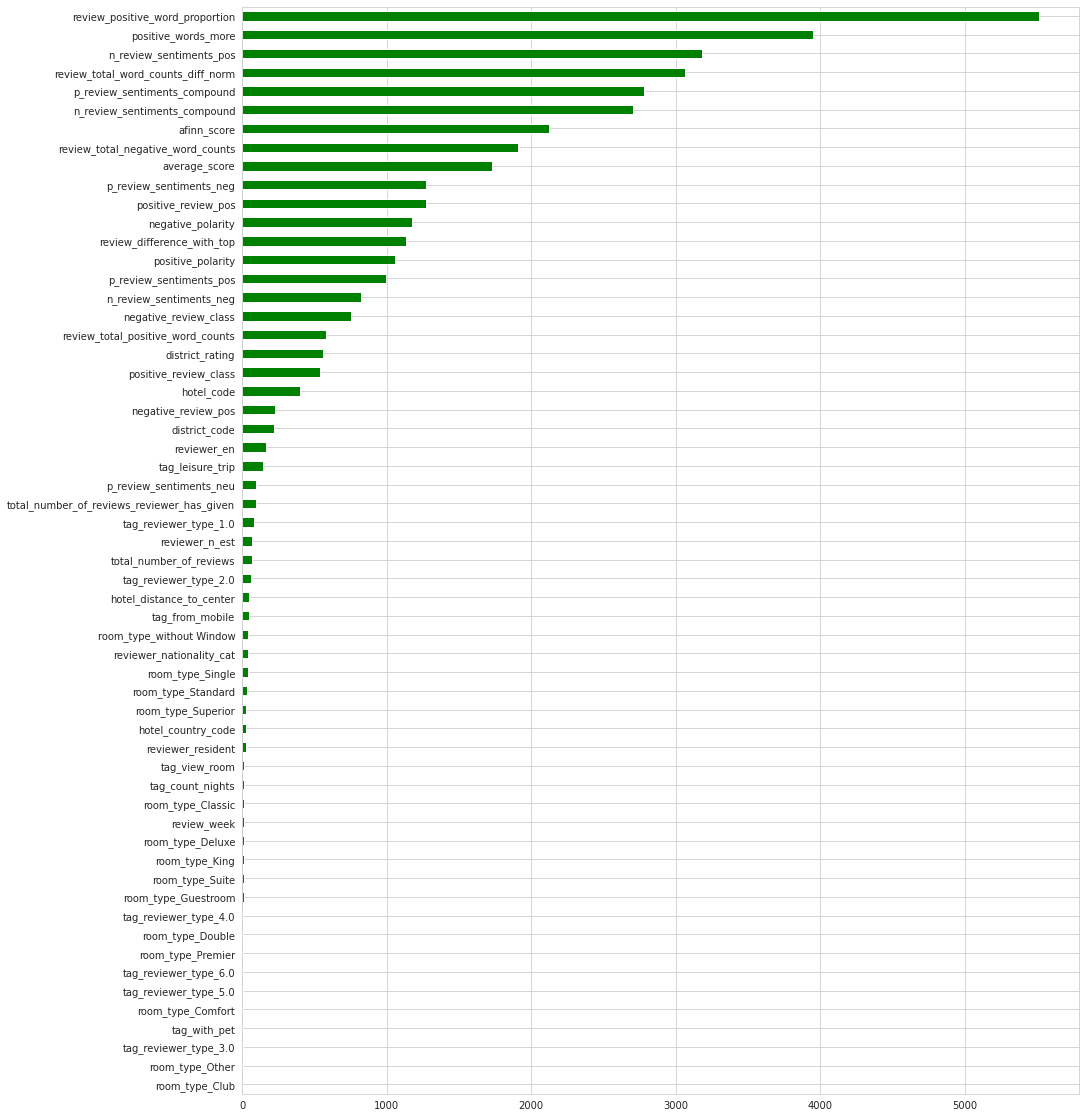

In [59]:
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# visualize the result of the significance analysis
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

We will remove the signs that do not show any correlation with the target. These are signs of some types of rooms and types of traveler, as well as a sign of travelers with animals.

Although I had a hypothesis that maybe their ratings are generally higher, since not many hotels allow guests with pets, and perhaps grateful hosts leave positive reviews. But no...

In [60]:
drop_columns = ['room_type_Other', 'room_type_Club', 'room_type_Comfort', 
                'room_type_Double', 'room_type_Premier', 'tag_with_pet',
                'tag_reviewer_type_3.0', 'tag_reviewer_type_4.0', 
                'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0']

In [61]:
# удалим незначимые числовые данные:
print(f'Deleting more {len(drop_columns)} columns with numeric data')
hotels_copy.drop(drop_columns, axis = 1, inplace=True)

print(f'The resulting total number of features: {len(hotels_copy.columns)}')
print('(including the "Sample" column and the target column)')

Deleting more 10 columns with numeric data
The resulting total number of features: 50
(including the "Sample" column and the target column)


#### 3. Training the model and obtaining a prediction (Model Building):
We break the dataframe into parts necessary for training and testing the model:

In [62]:
# now let's highlight the test part
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [63]:
# # let's use the special function train_test_split to separate the test data
# allocate 20% of the data for validation (the test_size parameter)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [64]:
# check the dimensions:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 49), (386803, 49), (386803, 48), (309442, 48), (77361, 48))

In [65]:
# # Create a model and get a prediction:
# # DO NOT TOUCH the SETTINGS
# model = RandomForestRegressor(
#     n_estimators=100, 
#     verbose=1, 
#     n_jobs=-1, 
#     random_state=RANDOM_SEED)

In [66]:
model = RandomForestRegressor(
    n_estimators=250, 
    min_samples_split= 2,
    max_features= 14,
    max_depth= None,
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)

In [67]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation

# try it out
# parameters = {'n_estimators': [100,125,150,175,200,225,250], 
#               'criterion': ['gini', 'entropy'], 
#               'max_depth': [2,4,6,8,10], 
#               'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 
#               'class_weight': [0.2,0.4,0.6,0.8,1.0],               
#               'min_samples_split': [2,3,4,5,6,7]}
# tuned_parameters = {'n_estimators': [250, 300, 350]}
# model = GridSearchCV(RandomForestRegressor(), 
#                             tuned_parameters,
#                             cv=5, 
#                             scoring="neg_mean_absolute_percentage_error",
#                             n_jobs=-1, 
#                             verbose=1) # cv=[5, 10] 'n_estimators': [3, 10, 30, 100, 500, 700, 1000]
# 'max_depth': [None, 1, 2, 3], 'min_samples_split': [2, 3], ,'max_features' : list(range(14, 22, 2))

In [68]:
%%time

# training the model on a test dataset
model.fit(X_train, y_train)

# we write the predicted values to the variable y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.8s


CPU times: user 14min 44s, sys: 5.05 s, total: 14min 49s
Wall time: 3min 49s


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    5.0s finished


In [69]:
# model.best_params_

In [70]:
# comparing the predicted values (y_pred) with the real ones (y_test), 
# the Mean Absolute Percentage Error (MAPE) metric shows the average absolute 
# percentage error of predicted values from actual

def mean_absolute_percentage_error(y_tr, y_pr):
    """Getting the average absolute error"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 11.84


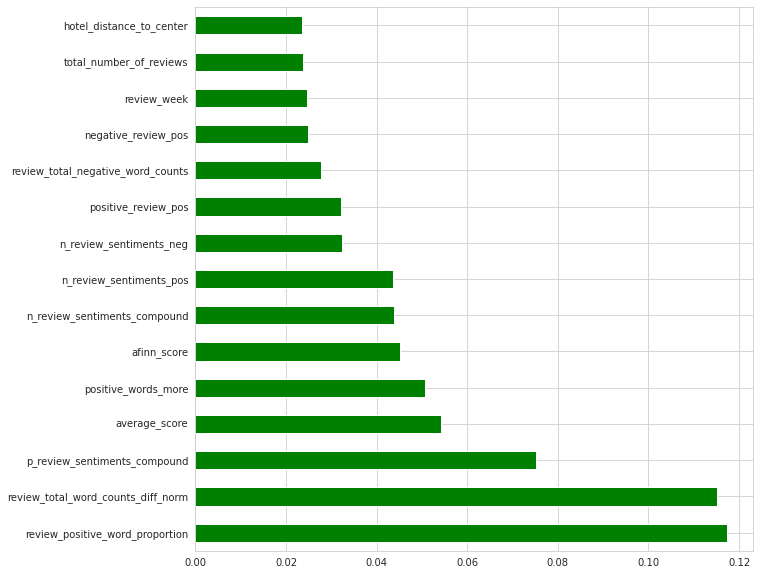

In [71]:
# Let's evaluate the contribution of the most important features to the construction of the model
# in RandomForestRegressor it is possible to display the most important features
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

In [72]:
# We get the prediction of the target variable
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

# saving the result:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    8.3s finished


,reviewer_score,id
0,8.598,488440
1,7.134,274649
2,8.242,374688
3,9.820,404352
4,9.540,451596
5,8.821,302161
6,7.935,317079
7,7.928,13963
8,8.269,159785
9,7.486,195089


Among the 15 main features for building a model with a final MAPE of 11.92, there are only two initial ones - the rating of the hotel and the total number of reviews about the hotel (an unfairly underestimated feature by me). The rest are features constructed in the process of data research. Considering that the MAPE criterion on raw data is 14.14%, only with the help of EDA tools I managed to improve it by about 15.5 percent. Among the most important signs are the distance to the center and the ratio of the number of words in different parts of the review. But of course, the main role was played by the signs responsible for determining the emotional coloring of the text.